In [1]:
import numpy as np
import scipy
import time
import sys
import scipy.io
import pandas as pd
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn import linear_model
import matplotlib.pyplot as plt

from utilities import *
from partition_class import *

In [2]:
def Friedman_function_gen(dimNum,dataNum):
    # Usage: generate the synthetic data through the Friedman's function
    # Input:
    # dimNum: number of dimensions for feature data
    # dataNum: number of data points

    # Sample from a uniform distribution
    xdata = uniform.rvs(size=(dataNum, dimNum))  
    
    # Sample from a sin of the x data.
    ydata = (10*np.sin(xdata[:, 0]*np.pi*xdata[:, 1])
#             + 20*((xdata[:, 2]-0.5)**2)
#             + 10*xdata[:, 3]
#             + 5*xdata[:, 4]
            + norm.rvs(size=dataNum))   # sample from standard normal

    return xdata, ydata

In [3]:
# parameters
dataNum = 1000
dimNum = 2
lambdas = 2
taus = 0.4

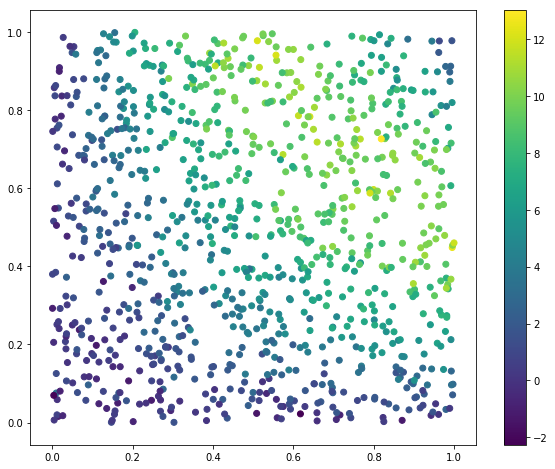

In [4]:
# Generate X and y training data (data)
xdata, ydata = Friedman_function_gen(dimNum, dataNum)

xdata[:,0]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(xdata[:,0], xdata[:,1], c=ydata)
plt.colorbar()
plt.show()

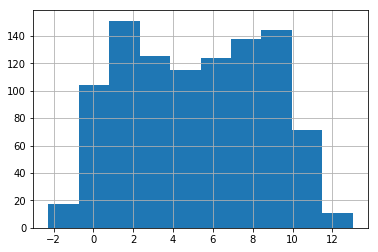

In [5]:
pd.Series(ydata).hist()

In [7]:
# Generate X and y training data (data)
xdata, ydata = Friedman_function_gen(dimNum, dataNum)

# Split the data into train and test with ratio 50/50
train_test_ratio = 0.5 # the ratio of test data

# preprocess data
(xdata_train, ydata_train,              # training set
xdata_test, ydata_test,                 # testing set
ydata_train_mean, dd,                   # mean
hyper_sigma_1, hyper_sigma_2,           # variance of the prior
variance_hat) = pre_process_data(xdata, ydata, train_test_ratio) # expected variance

# the length vector for all the dimensions
dimLength = np.ones(dimNum)*1.0

# number of iterations to run algorithm
IterationTime = 1000

# Initialise the RBP
RBP = PartitionPatch(dimLength, dataNum, taus, lambdas, np.mean(ydata_train), variance_hat)

# patchnum = int(taus * np.prod(1 + lambdas * dimLength))
print('Expected number of boxes is: '+str(RBP.patchNum))

predicted_value_train_seq = np.zeros((IterationTime, len(ydata_train)))
predicted_value_test_seq = np.zeros((IterationTime, len(ydata_test)))
train_RMAE_seq = np.zeros(IterationTime)
test_RMAE_seq = np.zeros(IterationTime)
Numbox = np.zeros(IterationTime)

Expected number of boxes is: 4


In [8]:
tt = 0
def run_iteration(tt):
    # complete 1 iteration
    RBP.Metropolis_Hastings_omegas(xdata_train, ydata_train)
    RBP.Metropolis_Hastings_A(xdata_train, ydata_train)
    RBP.hyperparameter_update(xdata_train, ydata_train, hyper_sigma_1, hyper_sigma_2)
    RBP.sample_patchNum(xdata_train, ydata_train)

    tvals_train = RBP.total_judge(xdata_train)
    predicted_value_train_seq[tt] = np.dot(tvals_train, RBP.omegas)
    tvals_test = RBP.total_judge(xdata_test)
    predicted_value_test_seq[tt] = np.dot(tvals_test, RBP.omegas)

    train_RMAE_seq[tt] = np.mean(abs(predicted_value_train_seq[tt]-ydata_train)*dd)
    test_RMAE_seq[tt] = np.mean(abs(predicted_value_test_seq[tt]-ydata_test)*dd)
    Numbox[tt] = RBP.patchNum

    print('============= Iteration '+str(tt+1) + ' finished. =============')
    print('Number of boxes is: '+ str(RBP.patchNum))
    
    tt+=1
    return tt

def plot_patches():    
    from matplotlib.patches import Rectangle
    from matplotlib.cm import ScalarMappable
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10,8))

    patches = RBP.patchPara
    
    rectangles = []
    for patch in patches:
        rect = Rectangle((patch[0][0], patch[1][0]), patch[0][1], patch[1][1])
        rectangles.append(rect)
        
    # Create patch collection with specified colour/alpha
    pc = PatchCollection(rectangles, cmap='viridis', alpha=0.05)
    
    pc.set_array(RBP.omegas)
    pc.set_edgecolor('black')    
    fig.colorbar(pc)
        
    # Add collection to axes
    ax.add_collection(pc)
    
    plt.show()

============= Iteration 1 finished. =============
Number of boxes is: 4


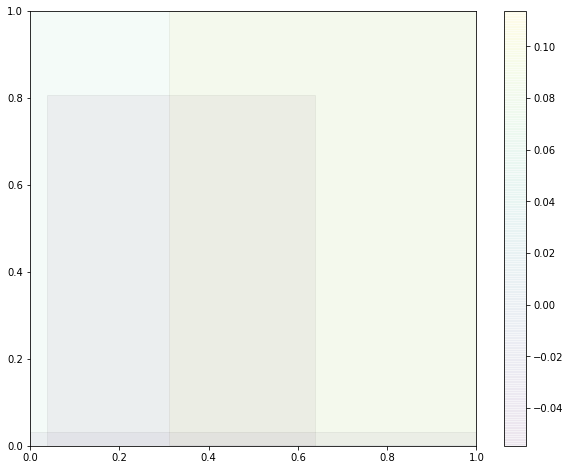

In [9]:
tt = run_iteration(tt)
plot_patches()

In [10]:
def total_judge(self, xdata): # jj = -1 denotes to calculate the whole likelihood
    # Usage: judge the belonging of each feature data

    # Input:
    # indicator matrix, size: N x K

    lower = self.patchPara[:, :, 0]             # lower corners of patches
    upper = np.sum(self.patchPara, axis=2)      # upper corners of patches
    judges = ((xdata[:, np.newaxis, :]>lower[np.newaxis, :, :])
             *(xdata[:, np.newaxis, :]<=upper[np.newaxis, :, :]))

#     return judges
    return np.prod(judges, axis=2).astype(bool)

In [11]:
lower = RBP.patchPara[:, :, 0]             # lower corners of patches
(xdata[:, np.newaxis, :]>lower[np.newaxis, :, :]).shape
# xdata

(1000, 4, 2)

In [12]:
RBP.patchPara[:,:,:]
# RBP.patchPara.shape
# RBP.omegas
total_judge(RBP, xdata)

array([[ True,  True, False, False],
       [ True,  True, False, False],
       [ True,  True, False, False],
       ...,
       [ True,  True, False, False],
       [ True,  True, False,  True],
       [ True,  True, False, False]])

============= Iteration 100 finished. =============
Number of boxes is: 10


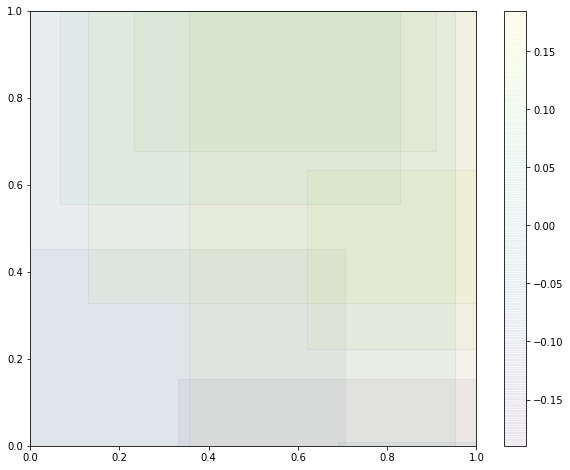

============= Iteration 200 finished. =============
Number of boxes is: 10


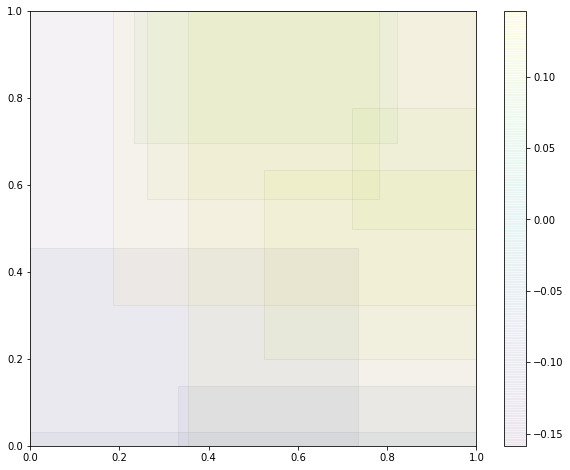

============= Iteration 300 finished. =============
Number of boxes is: 13


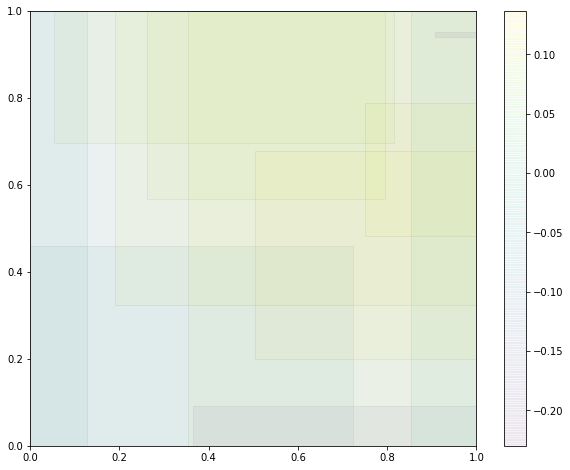

============= Iteration 400 finished. =============
Number of boxes is: 20


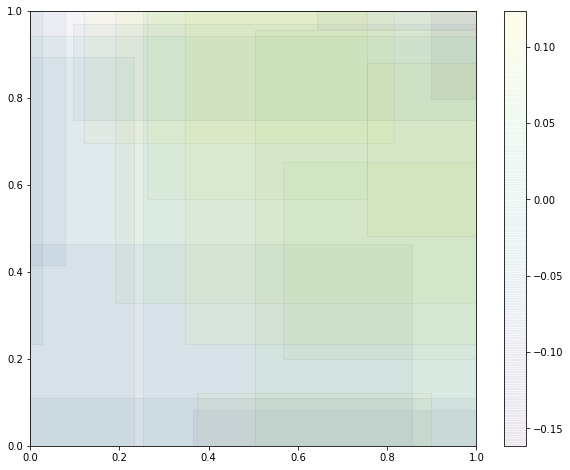

============= Iteration 500 finished. =============
Number of boxes is: 28


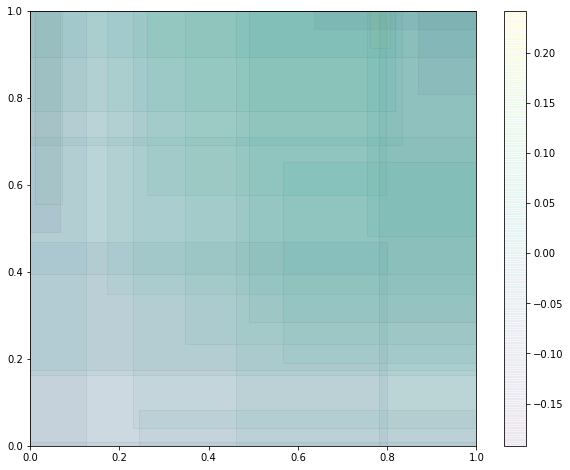

============= Iteration 600 finished. =============
Number of boxes is: 22


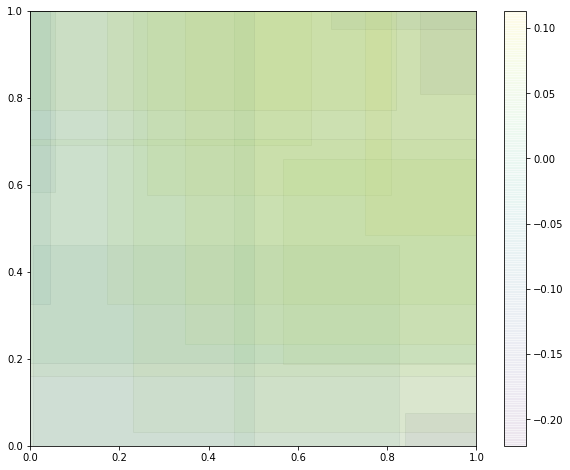

============= Iteration 700 finished. =============
Number of boxes is: 33


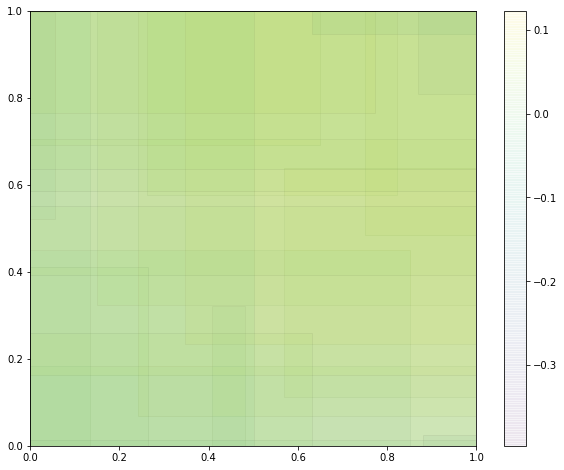

============= Iteration 800 finished. =============
Number of boxes is: 50


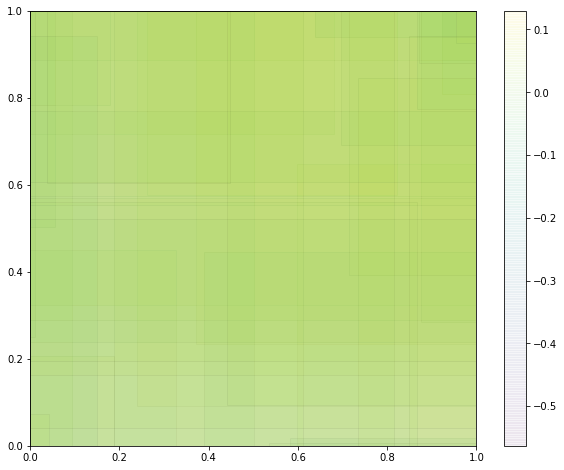

============= Iteration 900 finished. =============
Number of boxes is: 39


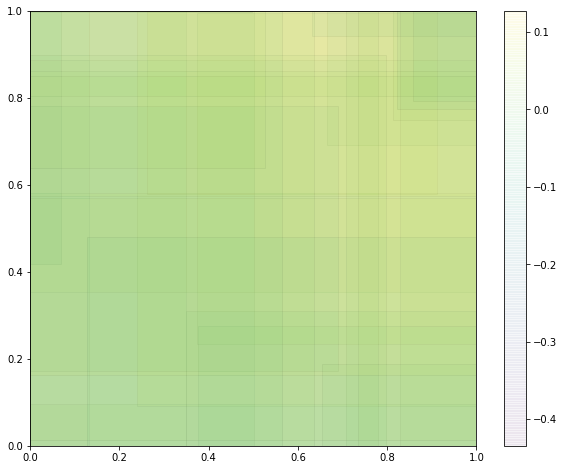

============= Iteration 1000 finished. =============
Number of boxes is: 37


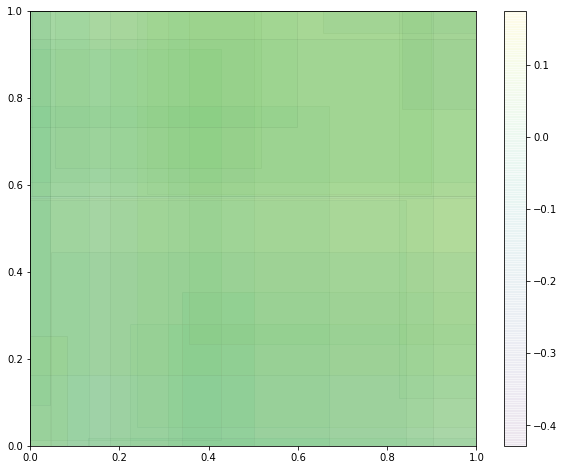

In [13]:
for tt in range(IterationTime):
    RBP.Metropolis_Hastings_omegas(xdata_train, ydata_train)
    RBP.Metropolis_Hastings_A(xdata_train, ydata_train)
    RBP.hyperparameter_update(xdata_train, ydata_train, hyper_sigma_1, hyper_sigma_2)
    RBP.sample_patchNum(xdata_train, ydata_train)

    tvals_train = RBP.total_judge(xdata_train)
    predicted_value_train_seq[tt] = np.dot(tvals_train, RBP.omegas)
    tvals_test = RBP.total_judge(xdata_test)
    predicted_value_test_seq[tt] = np.dot(tvals_test, RBP.omegas)

    train_RMAE_seq[tt] = np.mean(abs(predicted_value_train_seq[tt]-ydata_train)*dd)
    test_RMAE_seq[tt] = np.mean(abs(predicted_value_test_seq[tt]-ydata_test)*dd)
    Numbox[tt] = RBP.patchNum
    if np.mod(tt+1, 100)==0: # elementwise modulus operator
        print('============= Iteration '+str(tt+1) + ' finished. =============')
        print('Number of boxes is: '+ str(RBP.patchNum))
        plot_patches()

In [14]:
final_RMAE_train = np.mean(abs(
    np.mean(predicted_value_train_seq[int(IterationTime/2):,:], axis=0).reshape(-1)
            - ydata_train.reshape(-1)) * dd)

final_RMAE_test = np.mean(abs(
    np.mean(predicted_value_test_seq[int(IterationTime/2):,:], axis=0).reshape(-1)
            - ydata_test.reshape(-1)) * dd)

print('RBP-RT last train: '+str(train_RMAE_seq[-1])+', test: '+str(test_RMAE_seq[-1]))
print('RBP-RT train: '+str(final_RMAE_train)+', test: '+str(final_RMAE_test))

# compare_table = benchmark_compare(xdata_train, xdata_test, ydata_train, ydata_test, dd)

# np.savez_compressed('result/trial_1.npz', xdata_train = xdata_train, xdata_test = xdata_test, ydata_train= ydata_train,
#                     ydata_test=ydata_test, train_RMAE_seq=train_RMAE_seq, test_RMAE_seq = test_RMAE_seq,
#                     f_RMAE_train = final_RMAE_train, f_RMAE_test = final_RMAE_test, Numbox = Numbox,
#                     predicted_value_train_seq = predicted_value_train_seq, predicted_value_test_seq=predicted_value_test_seq,
#                     bechmark_table = compare_table)

RBP-RT last train: 0.7608964971634226, test: 1.0367636593394929
RBP-RT train: 0.6718436672612247, test: 0.9059012820397597


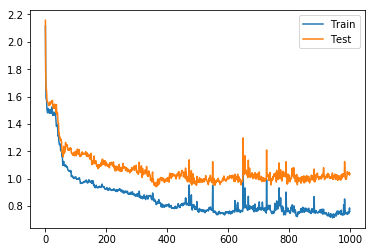

In [15]:
plt.plot(train_RMAE_seq)
plt.plot(test_RMAE_seq)
plt.legend(['Train', 'Test'])
plt.show()